# Exploring and Visualizing GFP Intensity Traces

## Overview
This project provides a workflow for exploring, preprocessing, and visualizing time-series fluorescence traces (e.g., GFP intensity) collected from multiple experimental conditions. The dataset (`all_traces.tsv`) is structured as labeled traces across videos, where each trace is measured over multiple time points.

The notebook performs the following steps:

1. **Data Loading and Indexing**  
   Load the `.tsv` dataset, create a MultiIndex (`label`, `video`, `trace`), and prepare timepoint columns.

2. **Exploratory Analysis**  
   Print dataset shapes, preview traces, and count traces per label and video.

3. **Visualization Functions**  
   - `rand_traces`: Plot 9 random traces from the dataset.  
   - `traces_by_video`: Plot sampled traces per video.  
   - `ecdf`: Plot empirical cumulative distribution functions (ECDF) of intensities per label.

4. **Statistical Summaries**  
   Compute per-label means and cumulative sums across timepoints.

5. **Normalization**  
   Apply Min-Max scaling to traces and save the normalized dataset.

6. **Top/Bottom Trace Analysis**  
   Identify and visualize the 10 highest and lowest traces per strain based on cumulative sum.

All plots and processed datasets are saved under the `Exploring_Dataset/` directory.

## Dataset
- **Input file:** `all_traces.tsv` (tab-separated values)  
- **Expected format:**  
  - **Index columns:** `label`, `video`, `trace`  
  - **Data columns:** `time_x` (e.g., `time_0`, `time_20`, …) representing timepoints

## Outputs
- **Plots (saved in `Exploring_Dataset/`):**  
  - Random traces: `Random_traces_raw.png`, `Random_traces_norm.png`  
  - Per-video sampled traces: `10_random_raw_traces_per_video.png`, `10_random_norm_traces_per_video.png`  
  - ECDF plots: `ECDF_raw_traces.png`, `ECDF_norm_traces.png`  
  - Cumulative sum analysis: `All_traces_by_cumulative_sum.png`

- **Processed datasets:**  
  - `all_traces_norm.tsv`: Min-Max normalized traces  
  - `all_traces_sorted_cum_sum.tsv`: Traces sorted by cumulative sum

## Usage
1. Place your `all_traces.tsv` file in the same directory as the notebook.  
2. Run the notebook cells in order.  
3. Outputs will be generated automatically in the `Exploring_Dataset/` folder.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import random
import os

In [2]:
# Create folder in which all figures and files are being saved
os.makedirs('Exploring_Dataset', exist_ok=True)

## Exploring dataset

In [3]:
# Load dataset (tab-separated file). Use sep='\t' for TSV.
data = pd.read_csv('../data/all_traces.tsv', sep='\t')
# Preview loaded dataset
data

label  video      trace   time_0  time_10  time_20  time_30  time_40  \
0      PR8   1001  trace_001  105.694  105.319  105.368  105.736  105.986   
1      PR8   1001  trace_002  105.778  104.826  105.014  104.972  105.542   
2      PR8   1001  trace_003  104.819  104.042  103.083  104.604  104.472   
3      PR8   1001  trace_004  103.306  103.062  103.062  102.792  102.694   
4      PR8   1001  trace_005  116.576  115.097  116.771  117.715  117.576   
...    ...    ...        ...      ...      ...      ...      ...      ...   
2820   X31   5003  trace_104  111.236  109.465  110.569  111.132  110.924   
2821   X31   5003  trace_105  107.492  106.892  108.833  108.083  108.042   
2822   X31   5003  trace_106  114.056  113.264  112.410  114.396  112.944   
2823   X31   5003  trace_107  109.868  109.056  109.201  110.194  109.278   
2824   X31   5003  trace_108  106.049  106.056  106.625  105.681  106.201   

      time_50  time_60  ...  time_510  time_520  time_530  time_540  time_550  \
0     106.014  105.208  ...   105.194   104.625   104.708   104.451   104.486   
1     105.056  105.479  ...   104.257   104.083   104.778   104.347   104.569   
2     104.326  104.444  ...   104.521   104.431   103.944   103.785   104.083   
3     103.264  103.451  ...   103.583   103.507   102.806   102.625   103.479   
4     116.104  115.410  ...   131.035   126.917   122.639   125.868   126.264   
...       ...      ...  ...       ...       ...       ...       ...       ...   
2820  111.764  112.597  ...   107.938   107.194   108.542   107.417   106.986   
2821  108.667  108.383  ...   106.625   107.175   107.100   106.208   106.867   
2822  114.354  114.097  ...   121.014   119.000   117.312   118.799   116.389   
2823  110.875  110.583  ...   110.292   110.549   110.465   110.354   110.229   
2824  105.847  105.986  ...   106.375   105.549   105.174   105.785   105.792   

      time_560  time_570  time_580  time_590  time_600  
0      104.910   104.951   105.222   104.396   104.375  
1      103.924   103.715   104.382   104.618   104.090  
2      104.368   103.472   103.736   103.833   105.097  
3      102.903   103.076   102.896   103.250   103.215  
4      124.875   122.917   118.000   121.806   121.069  
...        ...       ...       ...       ...       ...  
2820   107.167   107.583   107.507   107.472   106.764  
2821   106.400   106.775   107.167   106.392   108.025  
2822   116.778   117.312   117.521   116.708   117.000  
2823   109.618   109.493   111.132   111.576   110.750  
2824   106.451   106.174   105.215   105.028   105.340  

[2825 rows x 64 columns]

In [4]:
# Print shape of the dataset (= column and row count)
print("Shape of data before indexing:", data.shape)
# Ensure unique video names by prefixing with label to avoid mixing classes
data.video = data.apply(lambda s: f'{s.label}_{s.video}', axis=1)
# Set a multi-index (label, video, trace)
data = data.set_index(['label', 'video', 'trace'])
print("Shape of data after indexing:", data.shape) 

Shape of data before indexing: (2825, 64)
Shape of data after indexing: (2825, 61)


In [5]:
# Preview first 5 rows
data.head()

time_0  time_10  time_20  time_30  time_40  \
label video    trace                                                    
PR8   PR8_1001 trace_001  105.694  105.319  105.368  105.736  105.986   
               trace_002  105.778  104.826  105.014  104.972  105.542   
               trace_003  104.819  104.042  103.083  104.604  104.472   
               trace_004  103.306  103.062  103.062  102.792  102.694   
               trace_005  116.576  115.097  116.771  117.715  117.576   

                          time_50  time_60  time_70  time_80  time_90  ...  \
label video    trace                                                   ...   
PR8   PR8_1001 trace_001  106.014  105.208  105.632  105.681  105.778  ...   
               trace_002  105.056  105.479  105.535  105.125  105.056  ...   
               trace_003  104.326  104.444  103.917  104.236  104.236  ...   
               trace_004  103.264  103.451  103.243  103.465  103.264  ...   
               trace_005  116.104  115.410  117.181  118.021  117.785  ...   

                          time_510  time_520  time_530  time_540  time_550  \
label video    trace                                                         
PR8   PR8_1001 trace_001   105.194   104.625   104.708   104.451   104.486   
               trace_002   104.257   104.083   104.778   104.347   104.569   
               trace_003   104.521   104.431   103.944   103.785   104.083   
               trace_004   103.583   103.507   102.806   102.625   103.479   
               trace_005   131.035   126.917   122.639   125.868   126.264   

                          time_560  time_570  time_580  time_590  time_600  
label video    trace                                                        
PR8   PR8_1001 trace_001   104.910   104.951   105.222   104.396   104.375  
               trace_002   103.924   103.715   104.382   104.618   104.090  
               trace_003   104.368   103.472   103.736   103.833   105.097  
               trace_004   102.903   103.076   102.896   103.250   103.215  
               trace_005   124.875   122.917   118.000   121.806   121.069  

[5 rows x 61 columns]

In [6]:
# Count number of traces for each label (strain)
label_counts = data.index.get_level_values(0).value_counts()
print("Number of traces for each strain:\n",label_counts)

Number of traces for each strain:
 label
PR8    1853
X31     972
Name: count, dtype: int64


In [7]:
# Count number of unique videos per label
unique_videos = data.index.droplevel("trace").drop_duplicates()
video_counts = unique_videos.get_level_values("label").value_counts()
print("Number of videos for each strain:\n", video_counts)

Number of videos for each strain:
 label
PR8    17
X31    16
Name: count, dtype: int64


In [8]:
# Count number of traces per video
videos = data.index.get_level_values("video")
video_counts = videos.value_counts()
video_counts = video_counts.loc[videos.drop_duplicates()]
print("Number of traces for each video:\n", video_counts)

Number of traces for each video:
 video
PR8_1001     65
PR8_1002    120
PR8_1003    101
PR8_2001    117
PR8_2002    105
PR8_2003    106
PR8_2004    107
PR8_3001    158
PR8_3002    130
PR8_3003    122
PR8_4001    117
PR8_4002    107
PR8_4003    107
PR8_4004    108
PR8_5001     89
PR8_5002     98
PR8_5003     96
X31_1002     20
X31_1003     32
X31_2001    151
X31_2002    130
X31_2003    105
X31_3001     40
X31_3002     31
X31_3003     33
X31_3004     74
X31_4001     27
X31_4002     41
X31_4003     64
X31_4004     31
X31_5001     36
X31_5002     49
X31_5003    108
Name: count, dtype: int64


In [9]:
# Check number of timepoints
print(data.columns)
print("\nThere are", len(data.columns), "time points in total.")

Index(['time_0', 'time_10', 'time_20', 'time_30', 'time_40', 'time_50',
       'time_60', 'time_70', 'time_80', 'time_90', 'time_100', 'time_110',
       'time_120', 'time_130', 'time_140', 'time_150', 'time_160', 'time_170',
       'time_180', 'time_190', 'time_200', 'time_210', 'time_220', 'time_230',
       'time_240', 'time_250', 'time_260', 'time_270', 'time_280', 'time_290',
       'time_300', 'time_310', 'time_320', 'time_330', 'time_340', 'time_350',
       'time_360', 'time_370', 'time_380', 'time_390', 'time_400', 'time_410',
       'time_420', 'time_430', 'time_440', 'time_450', 'time_460', 'time_470',
       'time_480', 'time_490', 'time_500', 'time_510', 'time_520', 'time_530',
       'time_540', 'time_550', 'time_560', 'time_570', 'time_580', 'time_590',
       'time_600'],
      dtype='object')

There are 61 time points in total.


In [10]:
# Check multi-index
print(data.index)

MultiIndex([('PR8', 'PR8_1001', 'trace_001'),
            ('PR8', 'PR8_1001', 'trace_002'),
            ('PR8', 'PR8_1001', 'trace_003'),
            ('PR8', 'PR8_1001', 'trace_004'),
            ('PR8', 'PR8_1001', 'trace_005'),
            ('PR8', 'PR8_1001', 'trace_006'),
            ('PR8', 'PR8_1001', 'trace_007'),
            ('PR8', 'PR8_1001', 'trace_008'),
            ('PR8', 'PR8_1001', 'trace_009'),
            ('PR8', 'PR8_1001', 'trace_010'),
            ...
            ('X31', 'X31_5003', 'trace_099'),
            ('X31', 'X31_5003', 'trace_100'),
            ('X31', 'X31_5003', 'trace_101'),
            ('X31', 'X31_5003', 'trace_102'),
            ('X31', 'X31_5003', 'trace_103'),
            ('X31', 'X31_5003', 'trace_104'),
            ('X31', 'X31_5003', 'trace_105'),
            ('X31', 'X31_5003', 'trace_106'),
            ('X31', 'X31_5003', 'trace_107'),
            ('X31', 'X31_5003', 'trace_108')],
           names=['label', 'video', 'trace'], length=2825)


In [11]:
# Reload dataset to reset state and set index again
data = pd.read_csv('../data/all_traces.tsv', sep='\t')
data = data.set_index(['label', 'video', 'trace'])

# Clean column names: remove "time_" prefix, convert to integers
timepoints = data.columns.str.replace('time_', '')
data.columns = timepoints.astype(int)
# Check timepoints
print(data.columns)

Index([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410,
       420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550,
       560, 570, 580, 590, 600],
      dtype='int32')


## Raw traces

In [12]:
def compare_strains(
    df: pd.DataFrame,
    pr8_trace=None,
    x31_trace=None,
    dateiname='Exploring_Dataset/comparison_trace_per_strain.png',
    y_label='GFP intensity [a.u.]',
    seed=43
):
    """
    Plot one PR8 and one X31 trace side by side (exactly two subplots).
    Handles int/str video IDs and ensures no extra white space on the x-axis.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with MultiIndex (label, video, trace).
    pr8_trace : tuple or None, optional
        (video, trace) for PR8. Randomly sampled if None.
    x31_trace : tuple or None, optional
        (video, trace) for X31. Randomly sampled if None.
    dateiname : str, default='Exploring_Dataset/comparison_trace_per_strain.png'
        Output file name for saved figure.
    y_label : str, default='GFP intensity [a.u.]'
        Label for the y-axis.
    seed : int, default=43
        Random seed for reproducibility.
    """

    # --- Separate by strain ---
    pr8_df = df.loc['PR8']
    x31_df = df.loc['X31']

    # --- Pick traces ---
    if pr8_trace is None:
        pr8_trace = pr8_df.sample(n=1, random_state=seed).index[0]
    if x31_trace is None:
        x31_trace = x31_df.sample(n=1, random_state=seed).index[0]

    # --- Normalize ID types ---
    video_dtype = df.index.get_level_values('video').dtype
    if pd.api.types.is_integer_dtype(video_dtype):
        pr8_trace = (int(pr8_trace[0]), pr8_trace[1])
        x31_trace = (int(x31_trace[0]), x31_trace[1])
    else:
        pr8_trace = (str(pr8_trace[0]), pr8_trace[1])
        x31_trace = (str(x31_trace[0]), x31_trace[1])

    # --- Extract traces as Series ---
    pr8_row = df.loc[('PR8', pr8_trace[0], pr8_trace[1])]
    x31_row = df.loc[('X31', x31_trace[0], x31_trace[1])]

    # Flatten if necessary
    if isinstance(pr8_row, pd.DataFrame):
        pr8_row = pr8_row.squeeze(axis=0)
    if isinstance(x31_row, pd.DataFrame):
        x31_row = x31_row.squeeze(axis=0)

    # Convert x-axis (columns) to numeric
    pr8_row.index = pd.to_numeric(pr8_row.index, errors='coerce')
    x31_row.index = pd.to_numeric(x31_row.index, errors='coerce')

    # --- Determine x-axis limits (no white space) ---
    x_min = min(pr8_row.index.min(), x31_row.index.min())
    x_max = max(pr8_row.index.max(), x31_row.index.max())

    # --- Plot ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

    # PR8 subplot
    axs[0].plot(pr8_row.index, pr8_row.values, color='tab:blue')
    axs[0].set_title(f"PR8 | Video: {pr8_trace[0]} | Trace: {pr8_trace[1]}")
    axs[0].set_xlabel('Time [seconds]')
    axs[0].set_ylabel(y_label)
    axs[0].set_xlim(x_min, x_max)
    axs[0].grid(False)

    # X31 subplot
    axs[1].plot(x31_row.index, x31_row.values, color='tab:orange')
    axs[1].set_title(f"X31 | Video: {x31_trace[0]} | Trace: {x31_trace[1]}")
    axs[1].set_xlabel('Time [seconds]')
    axs[1].set_xlim(x_min, x_max)
    axs[1].grid(False)

    # --- Consistent tick styling ---
    for ax in axs:
        ax.tick_params(
            axis='both', which='both',
            bottom=True, top=False,
            left=True, right=False,
            length=4, width=0.8, color='black'
        )

    # --- Layout and save ---
    plt.tight_layout()
    fig.savefig(dateiname, dpi=300, bbox_inches='tight')
    plt.show()


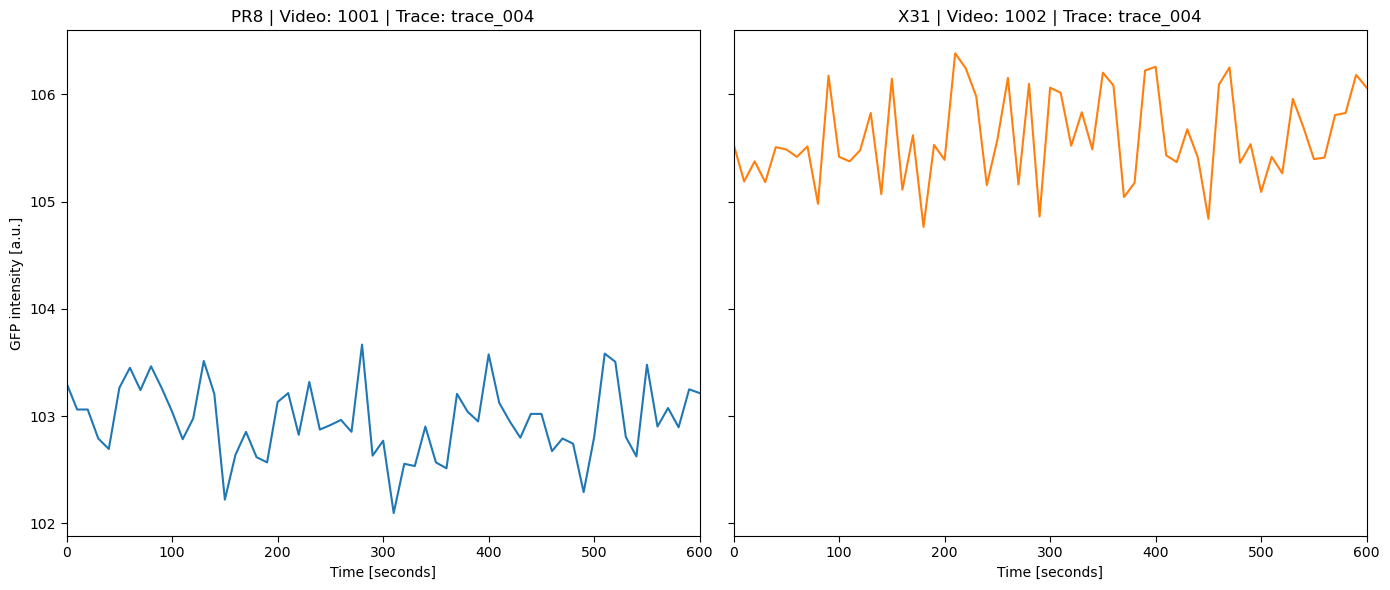

In [13]:
# Manually select traces
compare_strains(df=data, 
                pr8_trace=(1001,'trace_004'),
                x31_trace=(1002,'trace_004')
                )

# Or random (enter different seed in function above)
#compare_strains(data)

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_strains_overlap(
    df: pd.DataFrame,
    pr8_trace=None,
    x31_trace=None,
    dateiname='Exploring_Dataset/comparison_trace_per_strain_overlap.png',
    y_label='GFP intensity [a.u.]',
    seed=43
):
    """
    Plot one PR8 and one X31 trace together in a single plot (two lines).
    Handles int/str video IDs and ensures no extra white space on the x-axis.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with MultiIndex (label, video, trace).
    pr8_trace : tuple or None, optional
        (video, trace) for PR8. Randomly sampled if None.
    x31_trace : tuple or None, optional
        (video, trace) for X31. Randomly sampled if None.
    dateiname : str, default='Exploring_Dataset/comparison_trace_per_strain.png'
        Output file name for saved figure.
    y_label : str, default='GFP intensity [a.u.]'
        Label for the y-axis.
    seed : int, default=43
        Random seed for reproducibility.
    """

    # --- Separate by strain ---
    pr8_df = df.loc['PR8']
    x31_df = df.loc['X31']

    # --- Pick traces ---
    if pr8_trace is None:
        pr8_trace = pr8_df.sample(n=1, random_state=seed).index[0]
    if x31_trace is None:
        x31_trace = x31_df.sample(n=1, random_state=seed).index[0]

    # --- Normalize ID types ---
    video_dtype = df.index.get_level_values('video').dtype
    if pd.api.types.is_integer_dtype(video_dtype):
        pr8_trace = (int(pr8_trace[0]), pr8_trace[1])
        x31_trace = (int(x31_trace[0]), x31_trace[1])
    else:
        pr8_trace = (str(pr8_trace[0]), pr8_trace[1])
        x31_trace = (str(x31_trace[0]), x31_trace[1])

    # --- Extract traces as Series ---
    pr8_row = df.loc[('PR8', pr8_trace[0], pr8_trace[1])]
    x31_row = df.loc[('X31', x31_trace[0], x31_trace[1])]

    # Flatten if necessary
    if isinstance(pr8_row, pd.DataFrame):
        pr8_row = pr8_row.squeeze(axis=0)
    if isinstance(x31_row, pd.DataFrame):
        x31_row = x31_row.squeeze(axis=0)

    # Convert x-axis (columns) to numeric
    pr8_row.index = pd.to_numeric(pr8_row.index, errors='coerce')
    x31_row.index = pd.to_numeric(x31_row.index, errors='coerce')

    # --- Determine x-axis limits (no white space) ---
    x_min = min(pr8_row.index.min(), x31_row.index.min())
    x_max = max(pr8_row.index.max(), x31_row.index.max())

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(pr8_row.index, pr8_row.values, color='tab:blue', label=f"PR8 | Video: {pr8_trace[0]} | Trace: {pr8_trace[1]}")
    ax.plot(x31_row.index, x31_row.values, color='tab:orange', label=f"X31 | Video: {x31_trace[0]} | Trace: {x31_trace[1]}")

    ax.set_xlabel('Time [seconds]')
    ax.set_ylabel(y_label)
    ax.set_xlim(x_min, x_max)
    ax.legend()
    ax.grid(False)

    # --- Consistent tick styling ---
    ax.tick_params(
        axis='both', which='both',
        bottom=True, top=False,
        left=True, right=False,
        length=4, width=0.8, color='black'
    )

    plt.tight_layout()
    fig.savefig(dateiname, dpi=300, bbox_inches='tight')
    plt.show()

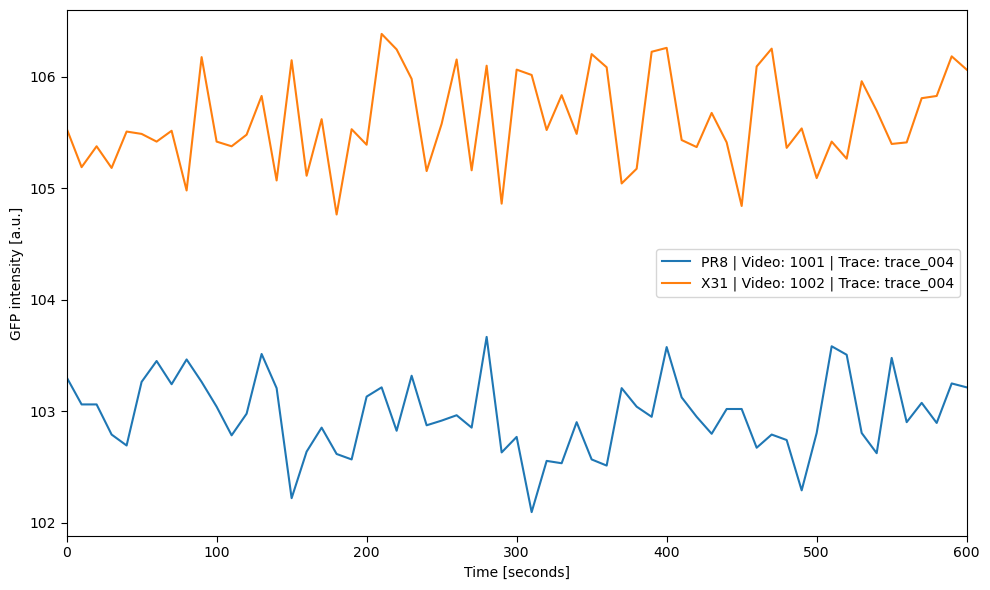

In [15]:
# Manually select traces
compare_strains_overlap(df=data, 
                        pr8_trace=(1001,'trace_004'),
                        x31_trace=(1002,'trace_004')
                       )

# Or random (enter different seed in function above)
#compare_strains(data)

In [16]:
# -------------------------------------------------
# Function: Plot sampled traces grouped by video with gradient color palettes
# -------------------------------------------------
def traces_by_video(
    df: pd.DataFrame,
    dateiname='plot.png',
    ncols=6,
    max_traces_per_group=10,
    seed=42,
    y_label='GFP intensity [a.u.]',
    figsize=(22, 17),
    title="10 representative raw traces for each strain and video",
):
    """
    Plot sampled traces grouped by (label, video).
    Each subplot shows up to `max_traces_per_group` traces.
    PR8 traces use 'Blues' colormap, X31 traces use 'Oranges' colormap.
    """

    # Time points (columns are time values)
    time_points = df.columns.astype(int)

    # Group data by label and video
    data_grouped = df.groupby([
        df.index.get_level_values('label'),
        df.index.get_level_values('video')
    ])
    groups = sorted(data_grouped.groups.keys())
    n_groups = len(groups)

    # Setup subplot grid
    nrows = int(np.ceil(n_groups / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, sharex=True, sharey=True)
    axes = axes.flatten()

    # Define colormaps
    cmap_pr8 = colormaps["Blues"]
    cmap_x31 = colormaps["Oranges"]

    for i, (label, video) in enumerate(groups):
        ax = axes[i]
        group_df = data_grouped.get_group((label, video))

        # Sample traces per group
        sampled_traces = group_df.sample(
            n=min(max_traces_per_group, len(group_df)), random_state=seed
        )

        # Select color palette based on strain
        if label == 'PR8':
            colors = [cmap_pr8(x) for x in np.linspace(0.2, 1, len(sampled_traces))]
        elif label == 'X31':
            colors = [cmap_x31(x) for x in np.linspace(0.2, 1, len(sampled_traces))]
        else:
            colors = ['gray'] * len(sampled_traces)

        # Plot traces with gradient colors
        for color, (_, row) in zip(colors, sampled_traces.iterrows()):
            ax.plot(time_points, row.values, color=color, alpha=0.9, linewidth=1.2)

        # Title formatting
        ax.set_title(f"{label}_{video}", fontsize=8)

        # --- Tick styling (NEW) ---
        ax.tick_params(
            axis='x', which='both',
            bottom=True, top=False,
            length=4, width=0.8, color='black'
        )
        ax.tick_params(
            axis='y', which='both',
            left=True, right=False,
            length=4, width=0.8, color='black'
        )

        # --- Bottom row: show x labels ---
        if i + ncols >= n_groups:
            ax.set_xlabel("Time [seconds]")
            ax.tick_params(axis='x', labelbottom=True)
            ax.set_xlim(time_points.min(), time_points.max())

            tick_indices = np.linspace(0, len(time_points) - 1, 7).astype(int)
            ax.set_xticks(time_points[tick_indices])
            ax.tick_params(axis='x', labelsize=8)
        else:
            ax.tick_params(axis='x', labelbottom=False)

        # --- Left column: show y labels ---
        if i % ncols == 0:
            ax.set_ylabel(y_label)
        else:
            ax.tick_params(axis='y', labelleft=False)

        ax.grid(False)

    # Remove unused axes if grid > groups
    for j in range(n_groups, len(axes)):
        fig.delaxes(axes[j])

    # --- Main title ---
    fig.suptitle(title, fontsize=20, y=1.0)
    plt.tight_layout()
    fig.savefig(dateiname, dpi=300, bbox_inches='tight')
    plt.show()

    return fig

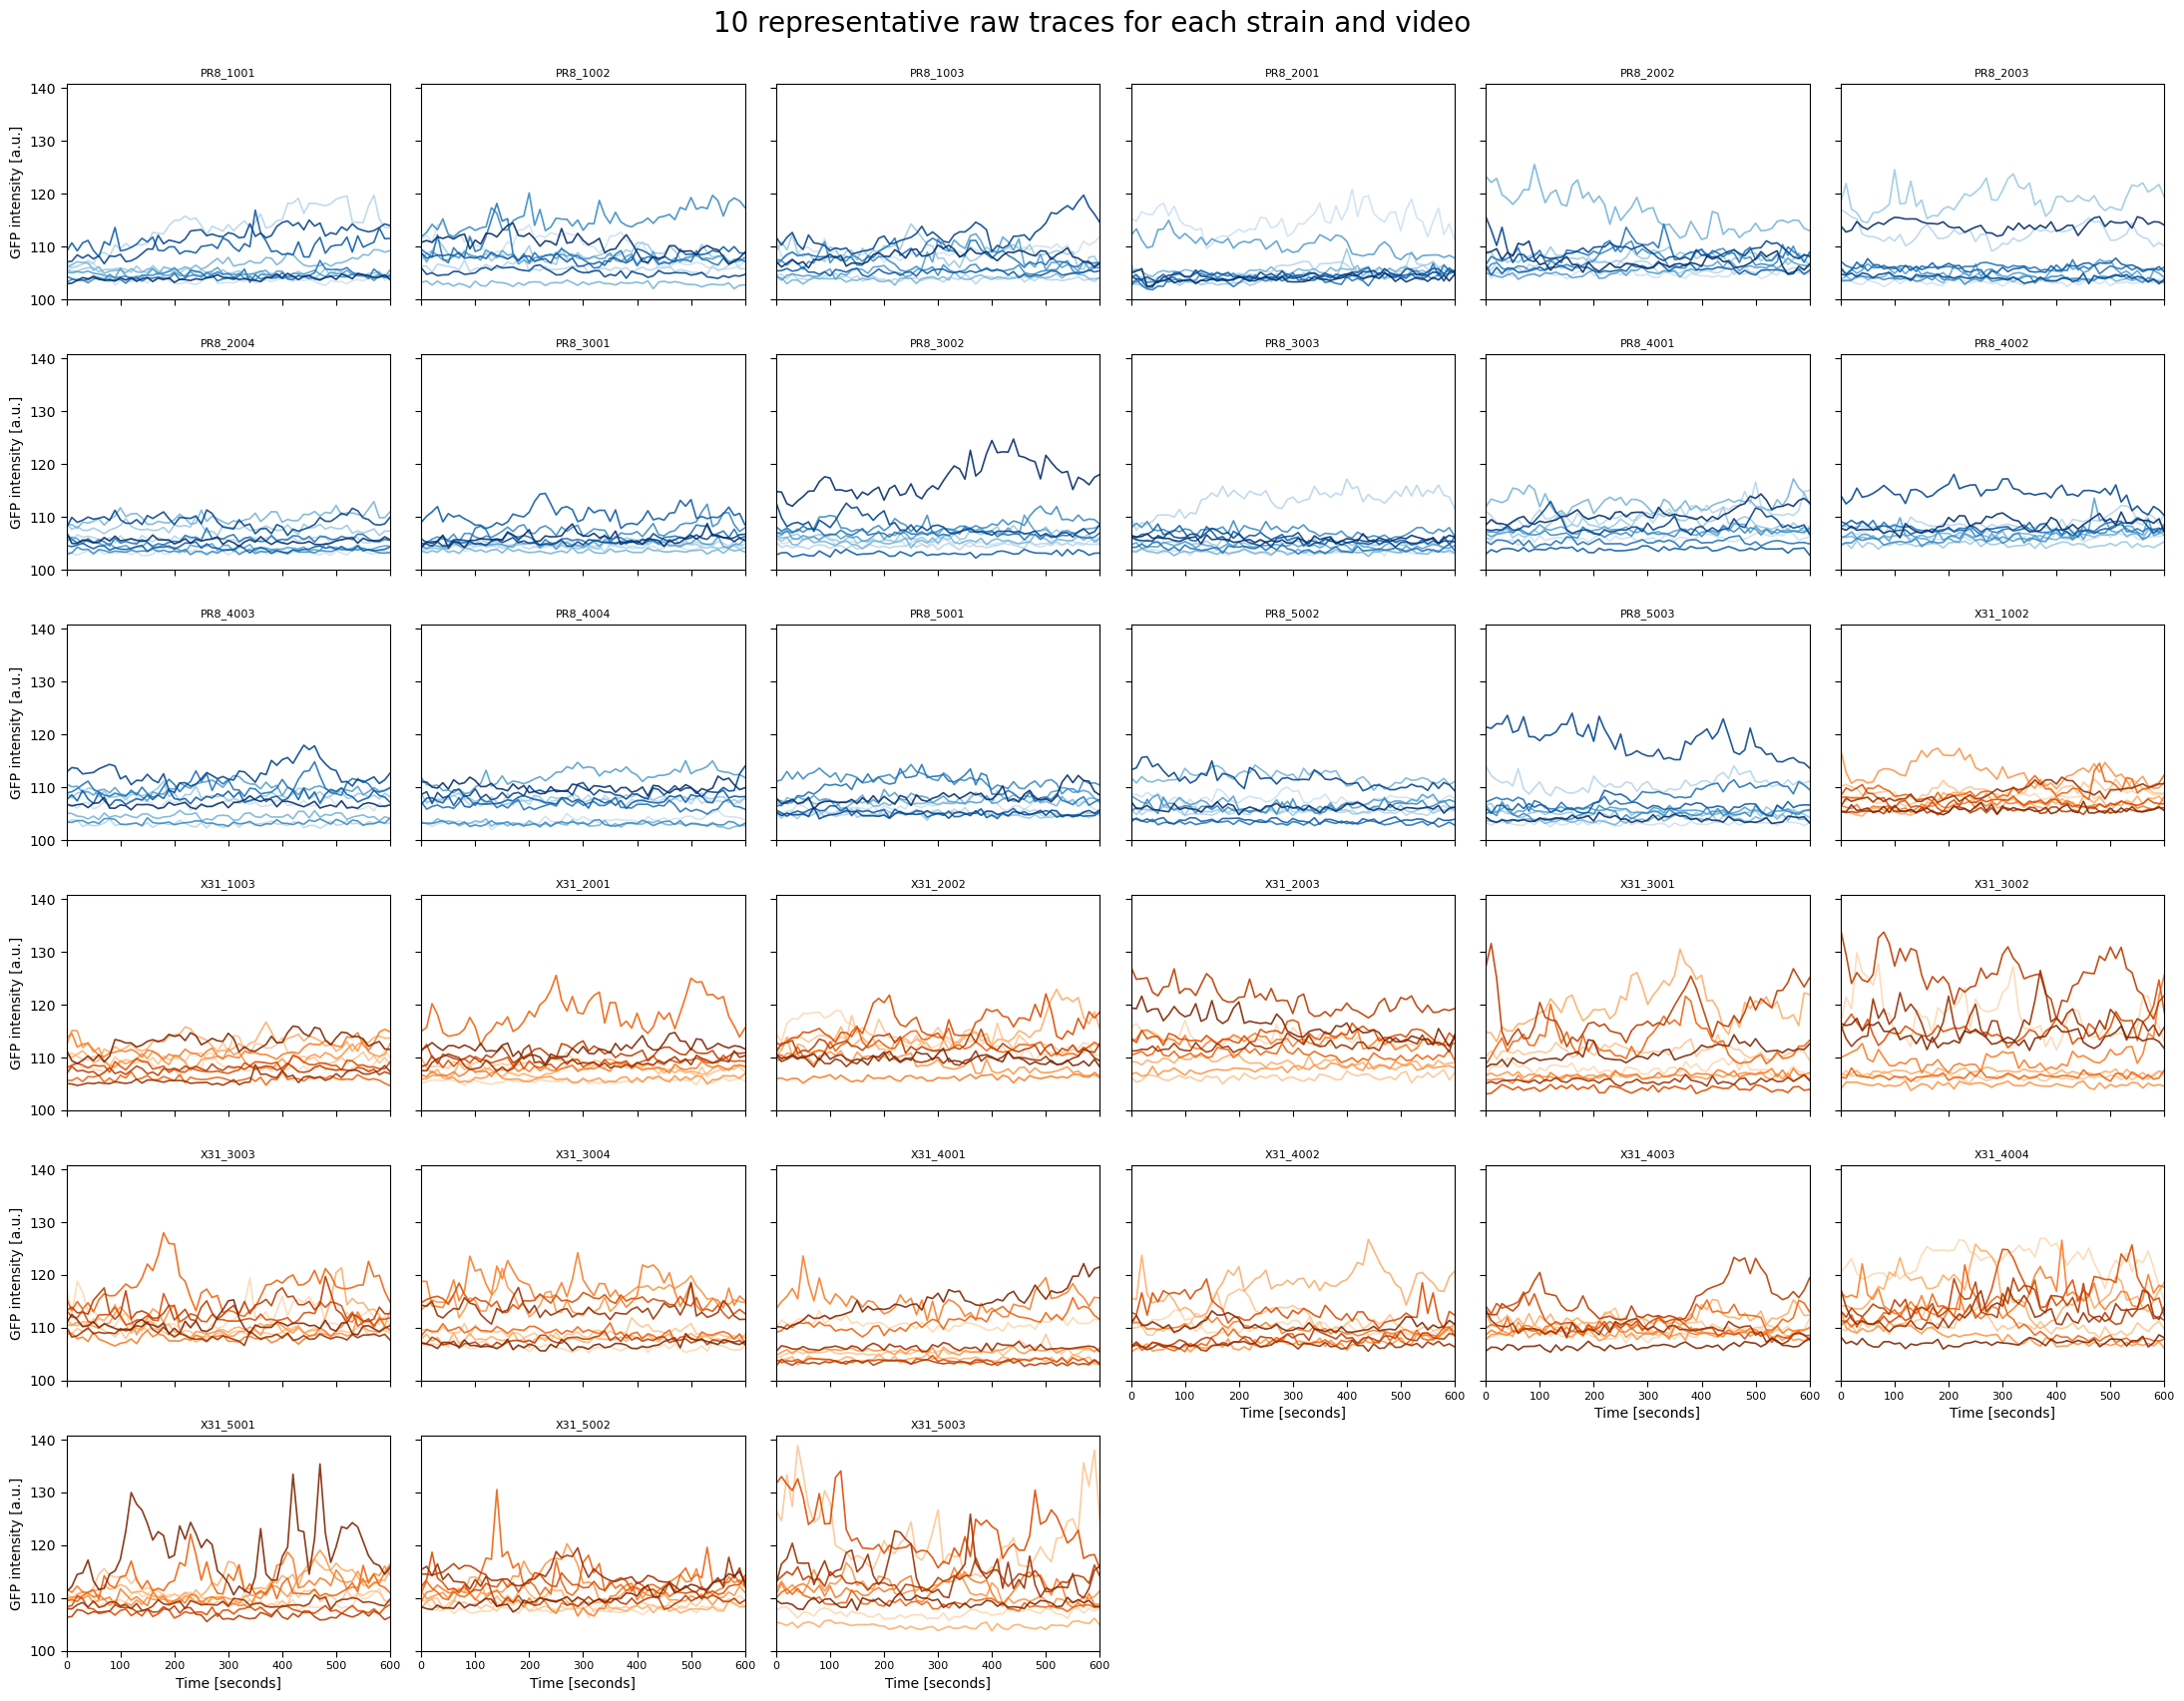

In [17]:
# Call the traces_by_video function
fig = traces_by_video(df=data, dateiname='Exploring_Dataset/10_random_raw_traces_per_video')
plt.show()

In [18]:
# -------------------------------------------------
# Function: ECDF plot
# -------------------------------------------------
def ecdf(
    df: pd.DataFrame,
    dateiname='plot.png',
    x_label='GFP intensity [a.u.]',
    title='ECDF for raw traces',
    figsize=(6, 5)
):
    """
    Plot ECDF curves for GFP intensity values grouped by (label, video).
    
    Parameters:
        df (pd.DataFrame): DataFrame with MultiIndex (label, video), and timepoints as columns.
        dateiname (str): Output filename for saved plot.
        x_label (str): Label for the x-axis.
        title (str): Plot title.
        figsize (tuple): Size of the figure.
        
    Returns:
        fig: The matplotlib Figure object.
    """

    # Group dataset by label and video
    data_grouped = df.groupby([df.index.get_level_values('label'), df.index.get_level_values('video')])
    groups = sorted(data_grouped.groups.keys())

    # Map colors to each label for plotting
    unique_labels = sorted(set(label for label, _ in groups))
    cmap = plt.get_cmap('tab10')
    colors = {label: cmap(i % cmap.N) for i, label in enumerate(unique_labels)}

    fig, ax = plt.subplots(figsize=figsize)

    # Flatten all values to determine x-axis limits
    all_values = df.values.flatten()
    all_values = all_values[~np.isnan(all_values)]
    xmin, xmax = np.min(all_values), np.max(all_values)

    # Plot ECDF for each video within each label
    for label, video in groups:
        group_df = data_grouped.get_group((label, video))
        values = group_df.values.flatten()
        values = values[~np.isnan(values)]

        x = np.sort(values)
        y = np.arange(1, len(x) + 1) / len(x)

        ax.step(x, y, where='post', color=colors[label], alpha=0.7, label=label)

    # Set labels and title
    ax.set_xlabel(x_label)
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(0, 1)
    
    # Remove duplicate legend entries per label
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=8, title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    fig.savefig(dateiname, dpi=300)
    return fig

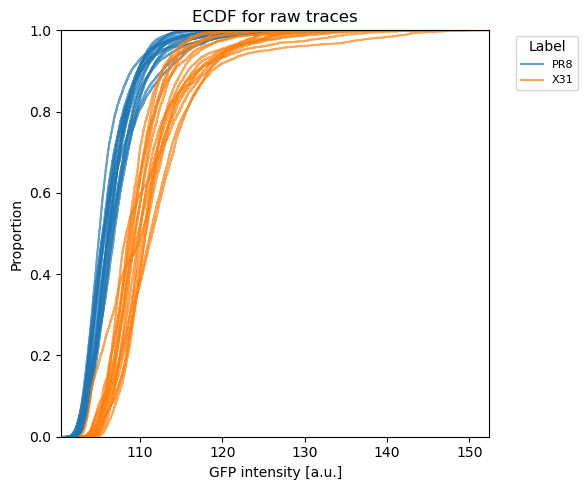

In [19]:
# Call the ecdf function
fig = ecdf(df=data, dateiname ='Exploring_Dataset/ECDF_raw_traces')
plt.show()

In [20]:
# Compute per-label statistics (mean and standard deviation)
# Each row represents one trace (e.g., one ROI), with timepoints as columns

# Calculate mean intensity per trace across time
trace_mean = data.mean(axis=1)

# Group by label (assuming 'label' is level 0 of MultiIndex)
per_label_mean = trace_mean.groupby(level='label').mean()
per_label_std = trace_mean.groupby(level='label').std()

# Combine results into a single DataFrame for better readability
per_label_stats = pd.DataFrame({
    'mean_intensity': per_label_mean,
    'std_intensity': per_label_std
})

print(per_label_stats)

       mean_intensity  std_intensity
label                               
PR8        106.671228       3.040277
X31        110.753687       4.225126


In [21]:
# Compute cumulative sum of each trace (row-wise sum across timepoints)
cum_sum = data.sum(axis=1)
# Group by label (level 0 of MultiIndex) and compute mean of those sums
label_mean_sums = cum_sum.groupby(level='label').mean()
# Print result
print(label_mean_sums)

label
PR8    6506.944888
X31    6755.974905
dtype: float64


## Normalized traces

In [22]:
# -------------------------------------------------
# Normalize dataset using Min-Max scaling
# -------------------------------------------------
def min_max(s: pd.Series | pd.DataFrame) -> pd.Series | pd.DataFrame:
    """
    Normalize values to range [0,1] using Min-Max scaling.
    """
    return (s - s.values.min()) / (s.values.max() - s.values.min())

# apply normalization function to each trace
data_norm = data.apply(min_max, axis=1)
# Check to see normalized dataset
print(data_norm)

# Save the normalized dataset as tsv-file
# Add "time_" back to the column names
data_norm.columns = ['time_' + str(col) for col in data_norm.columns]
print(data_norm.columns)

# Save the updated DataFrame
data_norm.to_csv('Exploring_Dataset/all_traces_norm.tsv', sep='\t', index=True)

                            0         10        20        30        40   \
label video trace                                                         
PR8   1001  trace_001  0.701169  0.544658  0.565109  0.718698  0.823038   
            trace_002  1.000000  0.612851  0.689305  0.672224  0.904026   
            trace_003  0.507009  0.280082  0.000000  0.444217  0.405666   
            trace_004  0.770064  0.614650  0.614650  0.442675  0.380255   
            trace_005  0.239840  0.162084  0.250092  0.299721  0.292414   
...                         ...       ...       ...       ...       ...   
X31   5003  trace_104  0.766672  0.463055  0.652323  0.748843  0.713184   
            trace_105  0.570880  0.378880  1.000000  0.760000  0.746880   
            trace_106  0.116022  0.060196  0.000000  0.139987  0.037640   
            trace_107  0.189023  0.010757  0.042591  0.260593  0.059495   
            trace_108  0.505195  0.508659  0.790203  0.323107  0.580406   

                        

In [23]:
# Remove 'time_' prefix again for plotting
timepoints = data_norm.columns.str.replace('time_', '')
# Convert year values to integers, saving results back to dataframe
data_norm.columns = timepoints.astype(int)
# Check if edit was successful
print(data_norm.columns)

Index([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270,
       280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410,
       420, 430, 440, 450, 460, 470, 480, 490, 500, 510, 520, 530, 540, 550,
       560, 570, 580, 590, 600],
      dtype='int32')


In [24]:
# Again select random traces to plot. Random state set to 5 so that it selects the same traces for result reproducibilit
random_traces_norm = data_norm.sample(n=9, random_state=5)
# Print to check
print(random_traces_norm)

                            0         10        20        30        40   \
label video trace                                                         
X31   3001  trace_003  0.000000  0.044472  0.165482  0.406524  0.032901   
      4002  trace_038  0.698913  0.584750  0.395874  0.727906  0.423055   
PR8   5002  trace_055  0.910692  0.312264  1.000000  0.480503  0.766352   
      4004  trace_088  0.222222  0.201087  0.371075  0.163345  0.429650   
X31   2001  trace_058  0.029051  0.085133  0.209675  0.229001  0.212328   
PR8   1003  trace_094  0.462417  0.530606  0.054868  0.149699  0.217888   
      5003  trace_008  0.600805  0.315329  0.053041  0.337545  0.330741   
X31   1003  trace_005  0.637695  0.830801  0.781875  0.555319  0.153818   
PR8   4003  trace_040  0.461421  0.233384  0.620703  0.599312  0.575630   

                            50        60        70        80        90   ...  \
label video trace                                                        ...   
X31   3001  tr

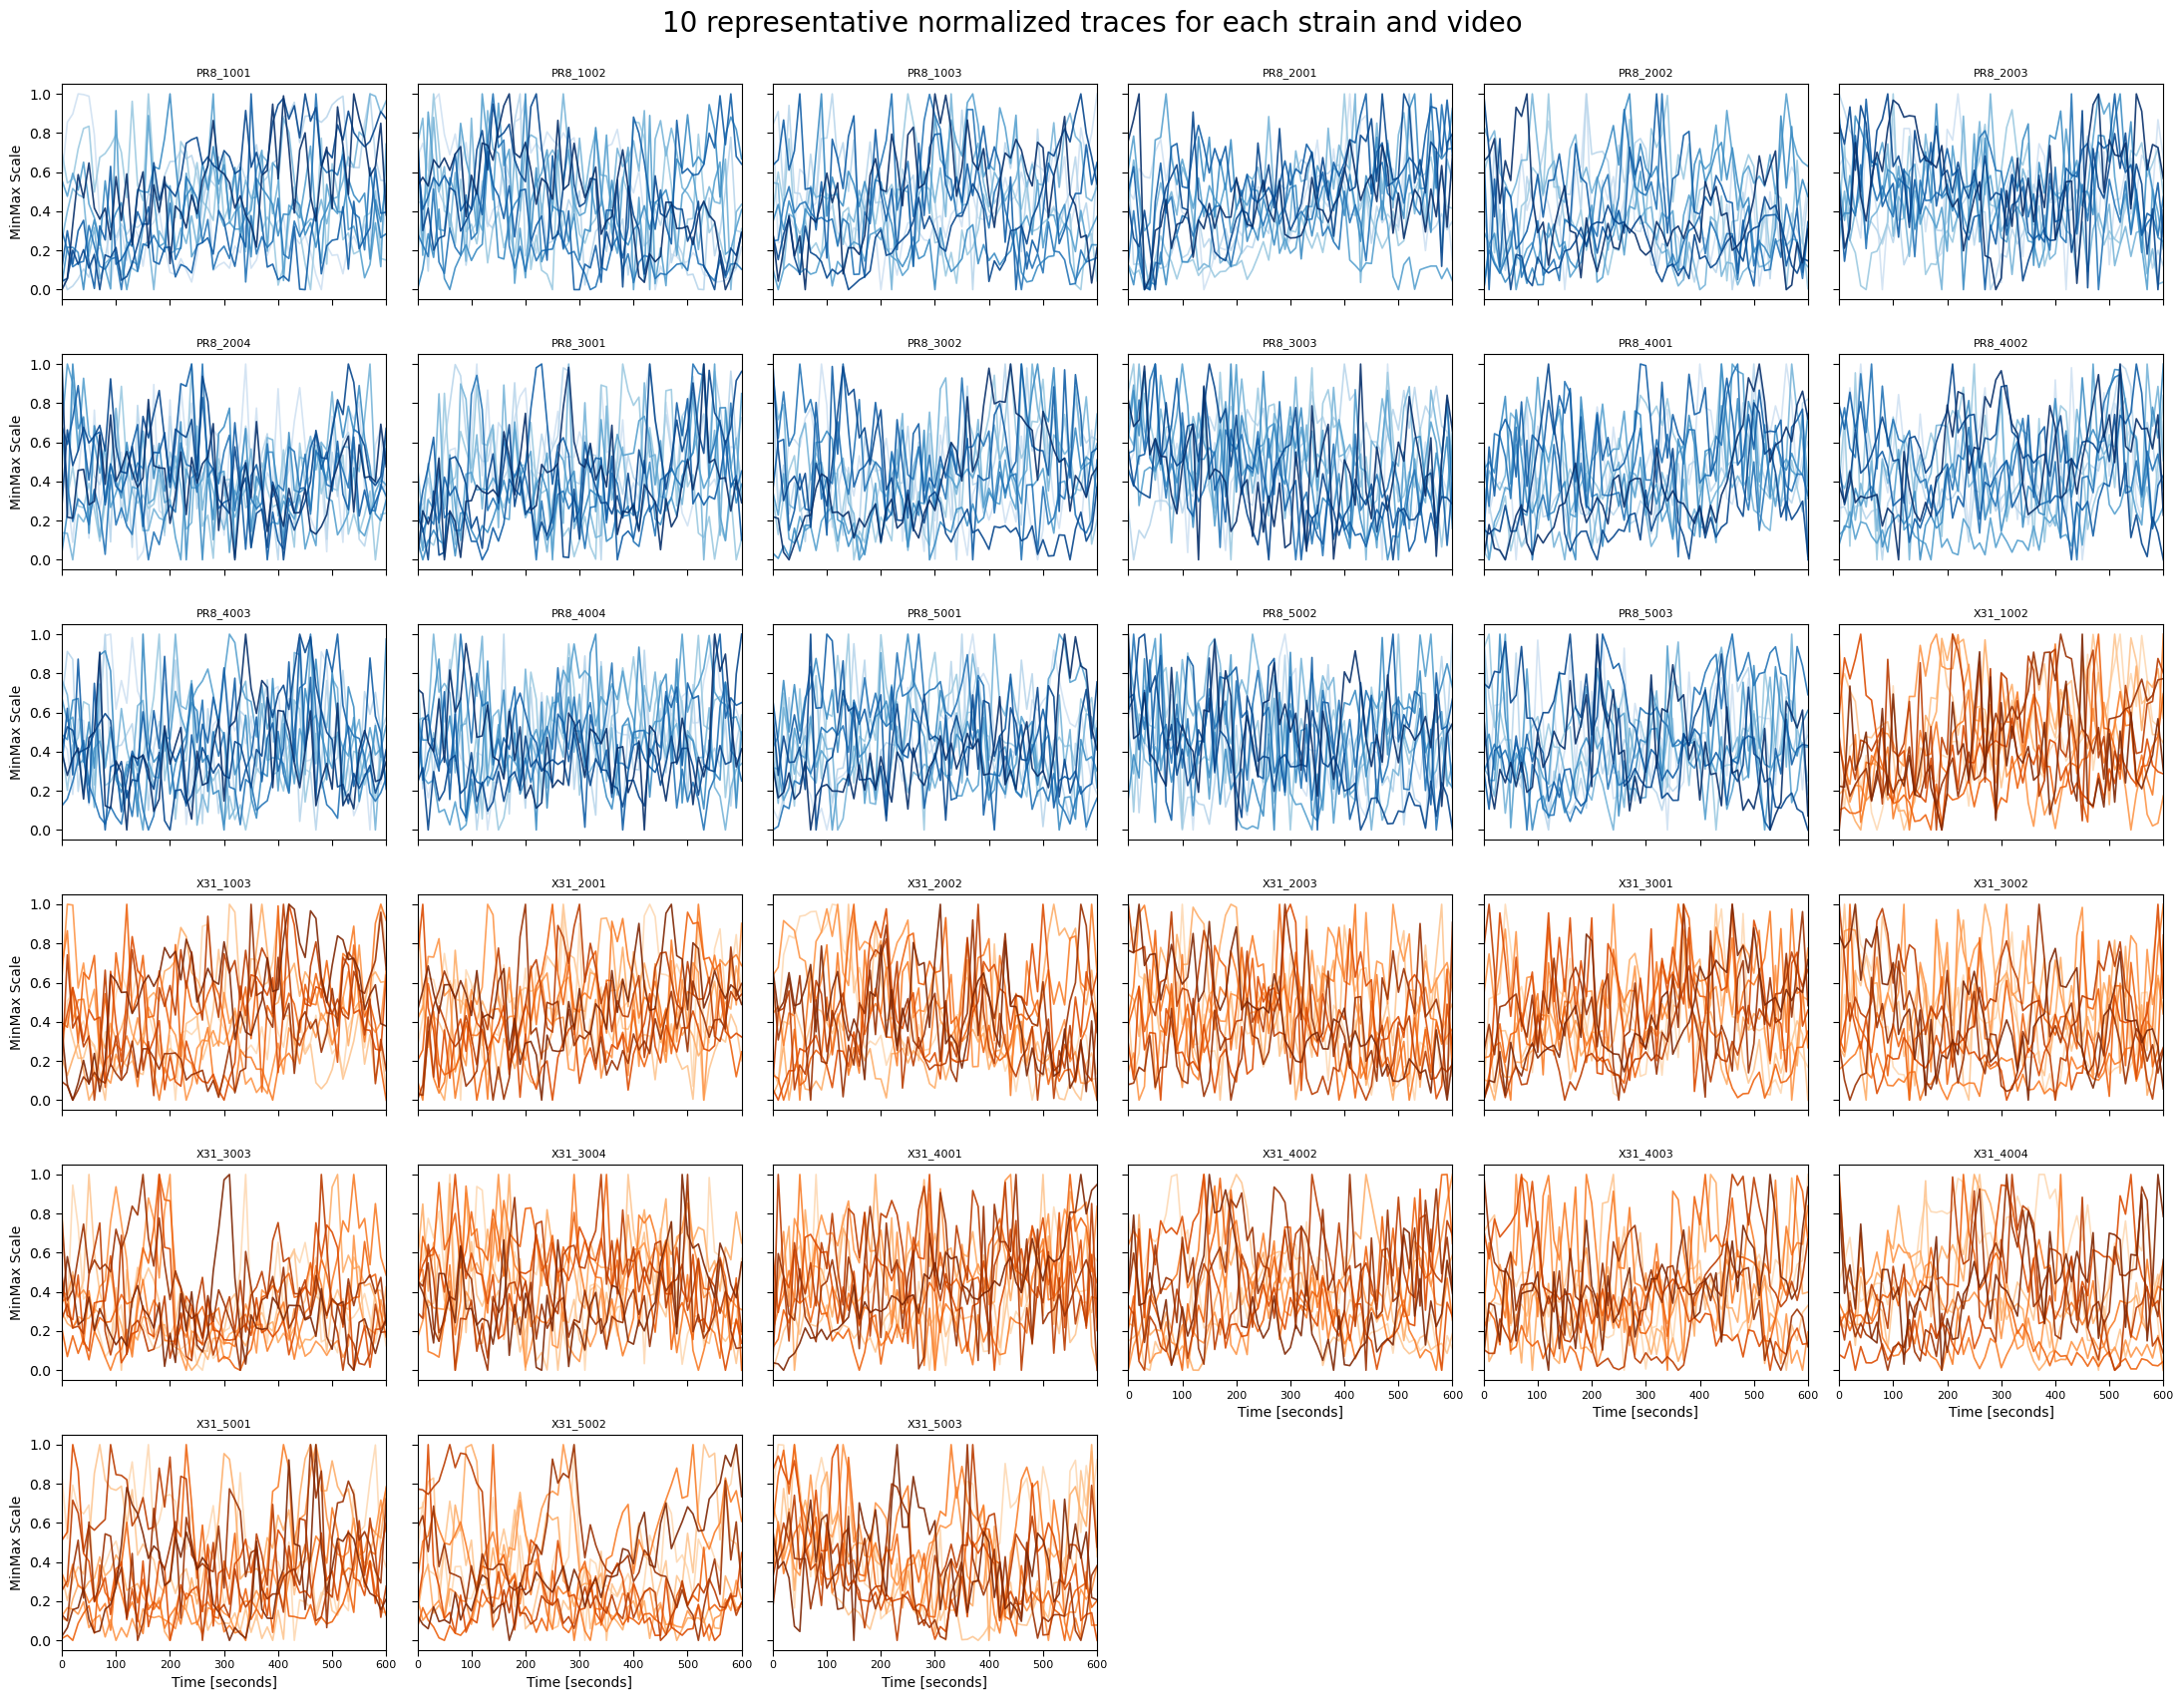

In [25]:
# Call the traces_by_video function for normalized traces
fig = traces_by_video(df=data_norm, dateiname='Exploring_Dataset/10_random_norm_traces_per_video', 
                      title='10 representative normalized traces for each strain and video', 
                      y_label='MinMax Scale')
plt.show()

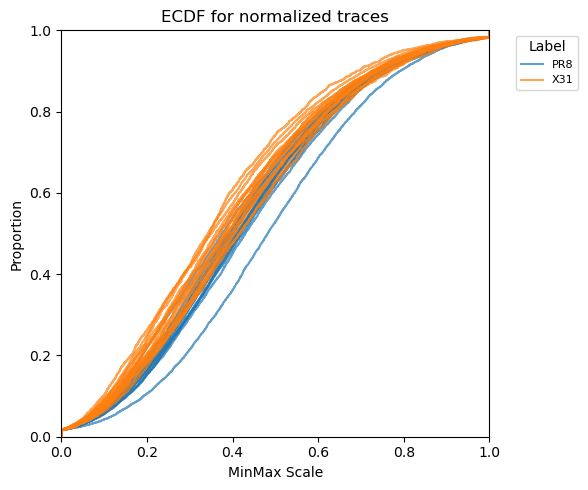

In [26]:
# Call the ecdf function for normalized traces
fig = ecdf(df=data_norm, dateiname='Exploring_Dataset/ECDF_norm_traces', title='ECDF for normalized traces', x_label='MinMax Scale')
plt.show()

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colormaps


def compare_two_traces_raw_vs_norm(
    df_raw: pd.DataFrame,
    df_norm: pd.DataFrame,
    strain: str = 'PR8',
    traces=None,
    dateiname='Exploring_Dataset/compare_two_traces_raw_vs_norm.png',
    y_label_raw='GFP intensity [a.u.]',
    y_label_norm='MinMax scale',
    seed=43,
):
    """
    Compare two traces of the same strain between raw and normalized datasets.
    Left subplot shows raw traces; right subplot shows normalized traces.

    Parameters
    ----------
    df_raw : pd.DataFrame
        Raw dataset with MultiIndex (label, video, trace).
    df_norm : pd.DataFrame
        Normalized dataset with same structure.
    strain : str, default='PR8'
        Strain label ('PR8' or 'X31').
    traces : list of tuples or None, optional
        List of two (video, trace) pairs. If None, two random traces are sampled.
    dateiname : str, default='Exploring_Dataset/compare_two_traces_raw_vs_norm.png'
        Output file path for saving the plot.
    y_label_raw : str, default='Raw GFP intensity [a.u.]'
        Label for the y-axis of the raw traces plot.
    y_label_norm : str, default='Normalized GFP intensity [a.u.]'
        Label for the y-axis of the normalized traces plot.
    seed : int, default=43
        Random seed for reproducibility.
    """

    # --- Validate input ---
    if strain not in df_raw.index.get_level_values('label'):
        raise ValueError(
            f"Strain '{strain}' not found in dataset. Available: "
            f"{df_raw.index.get_level_values('label').unique().tolist()}"
        )

    raw_df = df_raw.loc[strain]
    norm_df = df_norm.loc[strain]

    # --- Select traces ---
    if traces is None:
        traces = raw_df.sample(n=2, random_state=seed).index.tolist()
    elif len(traces) != 2:
        raise ValueError("Please provide exactly two traces, e.g. [(video1, trace1), (video2, trace2)].")

    # --- Normalize ID types ---
    video_dtype = df_raw.index.get_level_values('video').dtype
    formatted_traces = [
        (int(t[0]) if pd.api.types.is_integer_dtype(video_dtype) else str(t[0]), t[1])
        for t in traces
    ]

    # --- Color setup ---
    cmap = colormaps["Blues"] if strain == 'PR8' else colormaps["Oranges"]
    colors = [cmap(x) for x in np.linspace(0.4, 1.0, 2)]

    # --- Extract traces ---
    traces_raw, traces_norm = [], []
    for t in formatted_traces:
        raw_trace = df_raw.loc[(strain, t[0], t[1])]
        norm_trace = df_norm.loc[(strain, t[0], t[1])]

        # Flatten if necessary
        if isinstance(raw_trace, pd.DataFrame):
            raw_trace = raw_trace.squeeze()
        if isinstance(norm_trace, pd.DataFrame):
            norm_trace = norm_trace.squeeze()

        # Convert index (time) to numeric
        raw_trace.index = pd.to_numeric(raw_trace.index, errors='coerce')
        norm_trace.index = pd.to_numeric(norm_trace.index, errors='coerce')

        traces_raw.append(raw_trace)
        traces_norm.append(norm_trace)

    # --- Determine x-axis limits (no white space) ---
    x_min = min(t.index.min() for t in traces_raw + traces_norm)
    x_max = max(t.index.max() for t in traces_raw + traces_norm)

    # --- Plot setup ---
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

    # --- Left: raw traces ---
    for color, (t, trace_series) in zip(colors, zip(formatted_traces, traces_raw)):
        axs[0].plot(trace_series.index, trace_series.values, color=color, linewidth=1.5,
                    label=f"{t[0]} | {t[1]}")
    axs[0].set_title(f"Raw {strain} traces")
    axs[0].set_xlabel("Time [seconds]")
    axs[0].set_ylabel(y_label_raw)
    axs[0].set_xlim(x_min, x_max)
    axs[0].grid(False)
    axs[0].legend(fontsize=8)

    # --- Right: normalized traces ---
    for color, (t, trace_series) in zip(colors, zip(formatted_traces, traces_norm)):
        axs[1].plot(trace_series.index, trace_series.values, color=color, linewidth=1.5,
                    label=f"{t[0]} | {t[1]}")
    axs[1].set_title(f"Normalized {strain} traces")
    axs[1].set_xlabel("Time [seconds]")
    axs[1].set_ylabel(y_label_norm)
    axs[1].set_xlim(x_min, x_max)
    axs[1].grid(False)
    axs[1].legend(fontsize=8)

    # --- Consistent tick styling ---
    for ax in axs:
        ax.tick_params(
            axis='both', which='both',
            bottom=True, top=False,
            left=True, right=False,
            length=4, width=0.8, color='black'
        )

    # --- Title, layout, save ---
    fig.suptitle(f"Comparison of raw and normalized traces ({strain})", fontsize=20, y=1)
    plt.tight_layout()
    fig.savefig(dateiname, dpi=300, bbox_inches='tight')
    plt.show()

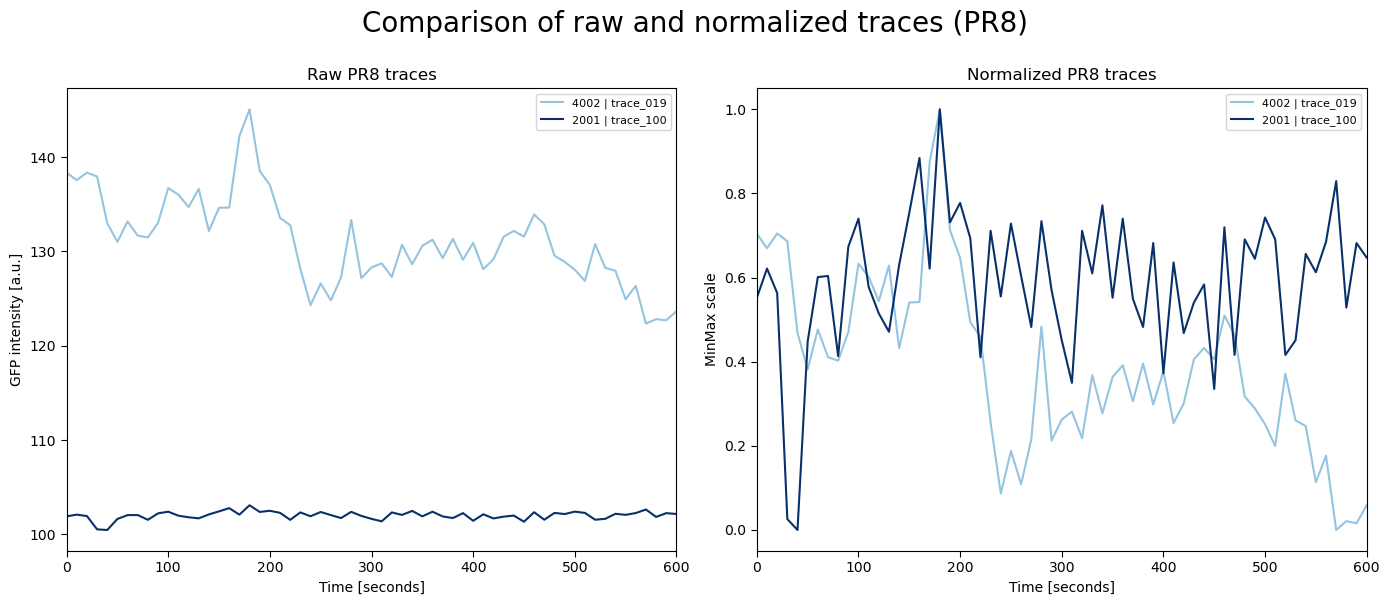

In [28]:
# Random selection
#compare_two_traces_raw_vs_norm(df_raw=data, df_norm=data_norm, strain='PR8')

# Manuell selection
compare_two_traces_raw_vs_norm(
    df_raw=data,
    df_norm=data_norm,
    dateiname='Exploring_Dataset/raw_vs_norm_traces_PR8',
    strain='PR8',
    traces=[(4002, 'trace_019'), (2001, 'trace_100')]
)

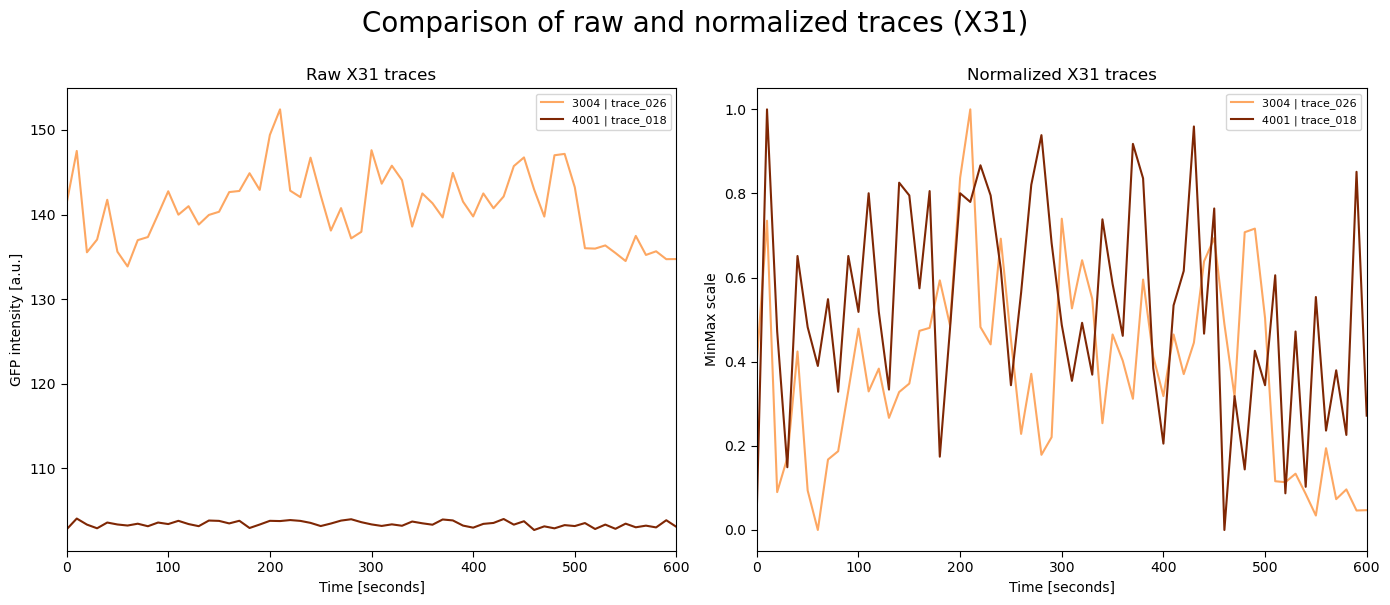

In [29]:
# Random selection
#compare_two_traces_raw_vs_norm(df_raw=data, df_norm=data_norm, strain='PR8')

# Manuell selection
compare_two_traces_raw_vs_norm(
    df_raw=data,
    df_norm=data_norm,
    dateiname='Exploring_Dataset/raw_vs_norm_traces_X31',
    strain='X31',
    traces=[(3004, 'trace_026'), (4001, 'trace_018')]
)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_strains_overlap(
    df: pd.DataFrame,
    pr8_trace=None,
    x31_trace=None,
    dateiname='Exploring_Dataset/comparison_trace_per_strain_overlap_norm.png',
    y_label='GFP intensity [a.u.]',
    seed=43
):
    """
    Plot one PR8 and one X31 trace together in a single plot (two lines).
    Handles int/str video IDs and ensures no extra white space on the x-axis.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataset with MultiIndex (label, video, trace).
    pr8_trace : tuple or None, optional
        (video, trace) for PR8. Randomly sampled if None.
    x31_trace : tuple or None, optional
        (video, trace) for X31. Randomly sampled if None.
    dateiname : str, default='Exploring_Dataset/comparison_trace_per_strain.png'
        Output file name for saved figure.
    y_label : str, default='GFP intensity [a.u.]'
        Label for the y-axis.
    seed : int, default=43
        Random seed for reproducibility.
    """

    # --- Separate by strain ---
    pr8_df = df.loc['PR8']
    x31_df = df.loc['X31']

    # --- Pick traces ---
    if pr8_trace is None:
        pr8_trace = pr8_df.sample(n=1, random_state=seed).index[0]
    if x31_trace is None:
        x31_trace = x31_df.sample(n=1, random_state=seed).index[0]

    # --- Normalize ID types ---
    video_dtype = df.index.get_level_values('video').dtype
    if pd.api.types.is_integer_dtype(video_dtype):
        pr8_trace = (int(pr8_trace[0]), pr8_trace[1])
        x31_trace = (int(x31_trace[0]), x31_trace[1])
    else:
        pr8_trace = (str(pr8_trace[0]), pr8_trace[1])
        x31_trace = (str(x31_trace[0]), x31_trace[1])

    # --- Extract traces as Series ---
    pr8_row = df.loc[('PR8', pr8_trace[0], pr8_trace[1])]
    x31_row = df.loc[('X31', x31_trace[0], x31_trace[1])]

    # Flatten if necessary
    if isinstance(pr8_row, pd.DataFrame):
        pr8_row = pr8_row.squeeze(axis=0)
    if isinstance(x31_row, pd.DataFrame):
        x31_row = x31_row.squeeze(axis=0)

    # Convert x-axis (columns) to numeric
    pr8_row.index = pd.to_numeric(pr8_row.index, errors='coerce')
    x31_row.index = pd.to_numeric(x31_row.index, errors='coerce')

    # --- Determine x-axis limits (no white space) ---
    x_min = min(pr8_row.index.min(), x31_row.index.min())
    x_max = max(pr8_row.index.max(), x31_row.index.max())

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(pr8_row.index, pr8_row.values, color='tab:blue', label=f"PR8 | Video: {pr8_trace[0]} | Trace: {pr8_trace[1]}")
    ax.plot(x31_row.index, x31_row.values, color='tab:orange', label=f"X31 | Video: {x31_trace[0]} | Trace: {x31_trace[1]}")

    ax.set_xlabel('Time [seconds]')
    ax.set_ylabel(y_label)
    ax.set_xlim(x_min, x_max)
    ax.legend()
    ax.grid(False)

    # --- Consistent tick styling ---
    ax.tick_params(
        axis='both', which='both',
        bottom=True, top=False,
        left=True, right=False,
        length=4, width=0.8, color='black'
    )

    plt.tight_layout()
    fig.savefig(dateiname, dpi=300, bbox_inches='tight')
    plt.show()

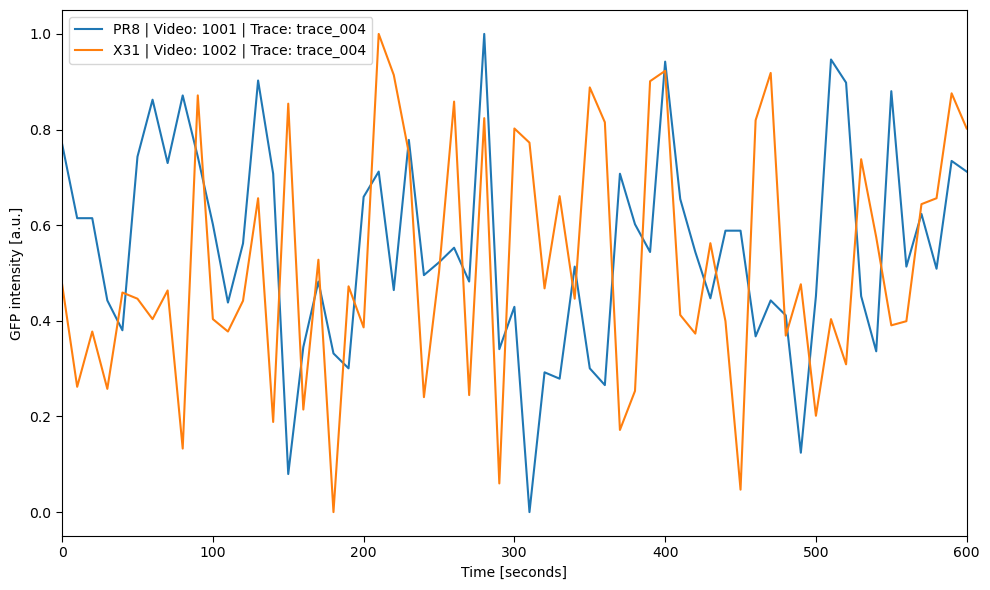

In [31]:
# Manually select traces
compare_strains_overlap(df=data_norm, 
                        pr8_trace=(1001,'trace_004'),
                        x31_trace=(1002,'trace_004')
                       )

# Or random (enter different seed in function above)
#compare_strains(data)

## Cumulative sum traces (optional)

In [32]:
# This part is optional
# Cumulative sum analysis: identify 10 highest and 10 lowest traces
# Compute row-wise sum for each trace
data_cum_sum = data.copy()
sum_rows = data_cum_sum.sum(axis=1)
print("Sum of values in each row: \n", sum_rows)

Sum of values in each row: 
 label  video  trace    
PR8    1001   trace_001    6413.975
              trace_002    6374.111
              trace_003    6373.144
              trace_004    6280.721
              trace_005    7216.815
                             ...   
X31    5003   trace_104    6661.702
              trace_105    6522.851
              trace_106    7169.971
              trace_107    6741.264
              trace_108    6458.814
Length: 2825, dtype: float64


In [33]:
# Add cumulative sum as a new column
data_cum_sum['cum_sum']= sum_rows
print(data_cum_sum.columns)

# Add cumulative sum as an additional index level
data_cum_sum = data_cum_sum.set_index('cum_sum', append=True)
print("\n", data_cum_sum.index.names, "\n")
data_cum_sum.head()

Index([        0,        10,        20,        30,        40,        50,
              60,        70,        80,        90,       100,       110,
             120,       130,       140,       150,       160,       170,
             180,       190,       200,       210,       220,       230,
             240,       250,       260,       270,       280,       290,
             300,       310,       320,       330,       340,       350,
             360,       370,       380,       390,       400,       410,
             420,       430,       440,       450,       460,       470,
             480,       490,       500,       510,       520,       530,
             540,       550,       560,       570,       580,       590,
             600, 'cum_sum'],
      dtype='object')

 ['label', 'video', 'trace', 'cum_sum'] 



0        10       20       30       40   \
label video trace     cum_sum                                                 
PR8   1001  trace_001 6413.975  105.694  105.319  105.368  105.736  105.986   
            trace_002 6374.111  105.778  104.826  105.014  104.972  105.542   
            trace_003 6373.144  104.819  104.042  103.083  104.604  104.472   
            trace_004 6280.721  103.306  103.062  103.062  102.792  102.694   
            trace_005 7216.815  116.576  115.097  116.771  117.715  117.576   

                                    50       60       70       80       90   \
label video trace     cum_sum                                                 
PR8   1001  trace_001 6413.975  106.014  105.208  105.632  105.681  105.778   
            trace_002 6374.111  105.056  105.479  105.535  105.125  105.056   
            trace_003 6373.144  104.326  104.444  103.917  104.236  104.236   
            trace_004 6280.721  103.264  103.451  103.243  103.465  103.264   
            trace_005 7216.815  116.104  115.410  117.181  118.021  117.785   

                                ...      510      520      530      540  \
label video trace     cum_sum   ...                                       
PR8   1001  trace_001 6413.975  ...  105.194  104.625  104.708  104.451   
            trace_002 6374.111  ...  104.257  104.083  104.778  104.347   
            trace_003 6373.144  ...  104.521  104.431  103.944  103.785   
            trace_004 6280.721  ...  103.583  103.507  102.806  102.625   
            trace_005 7216.815  ...  131.035  126.917  122.639  125.868   

                                    550      560      570      580      590  \
label video trace     cum_sum                                                 
PR8   1001  trace_001 6413.975  104.486  104.910  104.951  105.222  104.396   
            trace_002 6374.111  104.569  103.924  103.715  104.382  104.618   
            trace_003 6373.144  104.083  104.368  103.472  103.736  103.833   
            trace_004 6280.721  103.479  102.903  103.076  102.896  103.250   
            trace_005 7216.815  126.264  124.875  122.917  118.000  121.806   

                                    600  
label video trace     cum_sum            
PR8   1001  trace_001 6413.975  104.375  
            trace_002 6374.111  104.090  
            trace_003 6373.144  105.097  
            trace_004 6280.721  103.215  
            trace_005 7216.815  121.069  

[5 rows x 61 columns]

In [34]:
# Sort dataset by cumulative sum within each label (highest to lowest)
sorted_data = (
    data_cum_sum.groupby(level='label', group_keys=False)
        .apply(lambda df: df.sort_values(by='cum_sum', ascending=False))
)

# Save dataset sorted by cumulative sum
sorted_data.to_csv('Exploring_Dataset/all_traces_sorted_cum_sum.tsv', sep='\t', index=True)

In [35]:
sorted_data

0        10       20       30       40   \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  138.354  137.562  138.361  137.944  132.993   
      5001  trace_016 7841.577  130.729  129.097  130.146  132.931  132.729   
      2002  trace_005 7753.703  126.493  126.583  129.069  129.667  128.215   
      4003  trace_091 7525.960  125.792  126.347  127.785  125.750  123.389   
      1003  trace_003 7485.979  127.681  127.646  128.597  128.972  130.597   
...                                 ...      ...      ...      ...      ...   
X31   4001  trace_010 6347.890  103.632  103.944  104.111  104.514  102.993   
            trace_005 6341.290  102.903  104.243  103.847  103.104  103.417   
            trace_017 6330.593  104.000  103.424  103.771  103.660  104.028   
      2003  trace_030 6323.466  103.292  103.771  103.799  103.396  104.000   
      4001  trace_018 6308.457  102.778  104.062  103.347  102.910  103.590   

                                    50       60       70       80       90   \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  131.021  133.181  131.681  131.486  133.042   
      5001  trace_016 7841.577  130.479  133.007  133.847  134.347  134.944   
      2002  trace_005 7753.703  127.653  127.625  132.451  129.924  127.368   
      4003  trace_091 7525.960  124.889  123.576  126.688  128.465  130.542   
      1003  trace_003 7485.979  130.896  130.597  130.375  132.681  131.368   
...                                 ...      ...      ...      ...      ...   
X31   4001  trace_010 6347.890  103.597  104.688  104.097  104.090  104.062   
            trace_005 6341.290  103.819  104.333  103.931  104.333  104.042   
            trace_017 6330.593  103.521  104.146  104.174  104.083  104.000   
      2003  trace_030 6323.466  103.479  103.514  104.208  103.639  104.160   
      4001  trace_018 6308.457  103.361  103.236  103.451  103.153  103.590   

                                ...      510      520      530      540  \
label video trace     cum_sum   ...                                       
PR8   4002  trace_019 8000.863  ...  126.882  130.792  128.264  127.958   
      5001  trace_016 7841.577  ...  129.132  123.951  122.069  123.264   
      2002  trace_005 7753.703  ...  134.361  137.910  135.875  134.347   
      4003  trace_091 7525.960  ...  124.562  125.785  130.722  127.646   
      1003  trace_003 7485.979  ...  114.118  111.694  114.507  112.792   
...                             ...      ...      ...      ...      ...   
X31   4001  trace_010 6347.890  ...  104.410  103.479  104.132  103.694   
            trace_005 6341.290  ...  104.299  103.972  103.389  103.028   
            trace_017 6330.593  ...  103.910  103.535  104.382  103.278   
      2003  trace_030 6323.466  ...  103.639  103.785  103.340  104.299   
      4001  trace_018 6308.457  ...  103.528  102.826  103.347  102.847   

                                    550      560      570      580      590  \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  124.924  126.354  122.340  122.819  122.701   
      5001  trace_016 7841.577  119.764  120.028  120.271  120.062  118.333   
      2002  trace_005 7753.703  131.854  137.472  132.792  128.847  131.340   
      4003  trace_091 7525.960  127.382  130.118  130.451  135.757  127.653   
      1003  trace_003 7485.979  113.639  115.854  116.368  117.792  116.903   
...                                 ...      ...      ...      ...      ...   
X31   4001  trace_010 6347.890  104.882  104.597  104.062  104.486  103.250   
            trace_005 6341.290  103.507  103.764  104.646  103.826  103.694   
            trace_017 6330.593  104.340  103.806  104.118  103.271  103.979   
      2003  trace_030 6323.466  104.125  103.174  103.451  104.319  103.451   
      4001  trace_018 6308.457  103.458  103.028  103.22

In [36]:
# Select top 10 and bottom 10 traces per label
# Top 10 traces by cumulative sum
top10 = (
    data_cum_sum.groupby(level='label', group_keys=False)
        .apply(lambda df: df.sort_values('cum_sum', ascending=False).head(10))
)

# Bottom 10 traces by cumulative sum
bottom10 = (
    data_cum_sum.groupby(level='label', group_keys=False)
        .apply(lambda df: df.sort_values('cum_sum', ascending=False).tail(10))
)

# Combine top and bottom traces
top_and_bottom_10 = pd.concat([top10, bottom10])

# Sort again (just for printing)
top_and_bottom_10 = top_and_bottom_10.sort_values(['label', 'cum_sum'], ascending=[True, False])

In [37]:
top_and_bottom_10.head()

0        10       20       30       40   \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  138.354  137.562  138.361  137.944  132.993   
      5001  trace_016 7841.577  130.729  129.097  130.146  132.931  132.729   
      2002  trace_005 7753.703  126.493  126.583  129.069  129.667  128.215   
      4003  trace_091 7525.960  125.792  126.347  127.785  125.750  123.389   
      1003  trace_003 7485.979  127.681  127.646  128.597  128.972  130.597   

                                    50       60       70       80       90   \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  131.021  133.181  131.681  131.486  133.042   
      5001  trace_016 7841.577  130.479  133.007  133.847  134.347  134.944   
      2002  trace_005 7753.703  127.653  127.625  132.451  129.924  127.368   
      4003  trace_091 7525.960  124.889  123.576  126.688  128.465  130.542   
      1003  trace_003 7485.979  130.896  130.597  130.375  132.681  131.368   

                                ...      510      520      530      540  \
label video trace     cum_sum   ...                                       
PR8   4002  trace_019 8000.863  ...  126.882  130.792  128.264  127.958   
      5001  trace_016 7841.577  ...  129.132  123.951  122.069  123.264   
      2002  trace_005 7753.703  ...  134.361  137.910  135.875  134.347   
      4003  trace_091 7525.960  ...  124.562  125.785  130.722  127.646   
      1003  trace_003 7485.979  ...  114.118  111.694  114.507  112.792   

                                    550      560      570      580      590  \
label video trace     cum_sum                                                 
PR8   4002  trace_019 8000.863  124.924  126.354  122.340  122.819  122.701   
      5001  trace_016 7841.577  119.764  120.028  120.271  120.062  118.333   
      2002  trace_005 7753.703  131.854  137.472  132.792  128.847  131.340   
      4003  trace_091 7525.960  127.382  130.118  130.451  135.757  127.653   
      1003  trace_003 7485.979  113.639  115.854  116.368  117.792  116.903   

                                    600  
label video trace     cum_sum            
PR8   4002  trace_019 8000.863  123.674  
      5001  trace_016 7841.577  119.486  
      2002  trace_005 7753.703  130.618  
      4003  trace_091 7525.960  126.417  
      1003  trace_003 7485.979  119.111  

[5 rows x 61 columns]

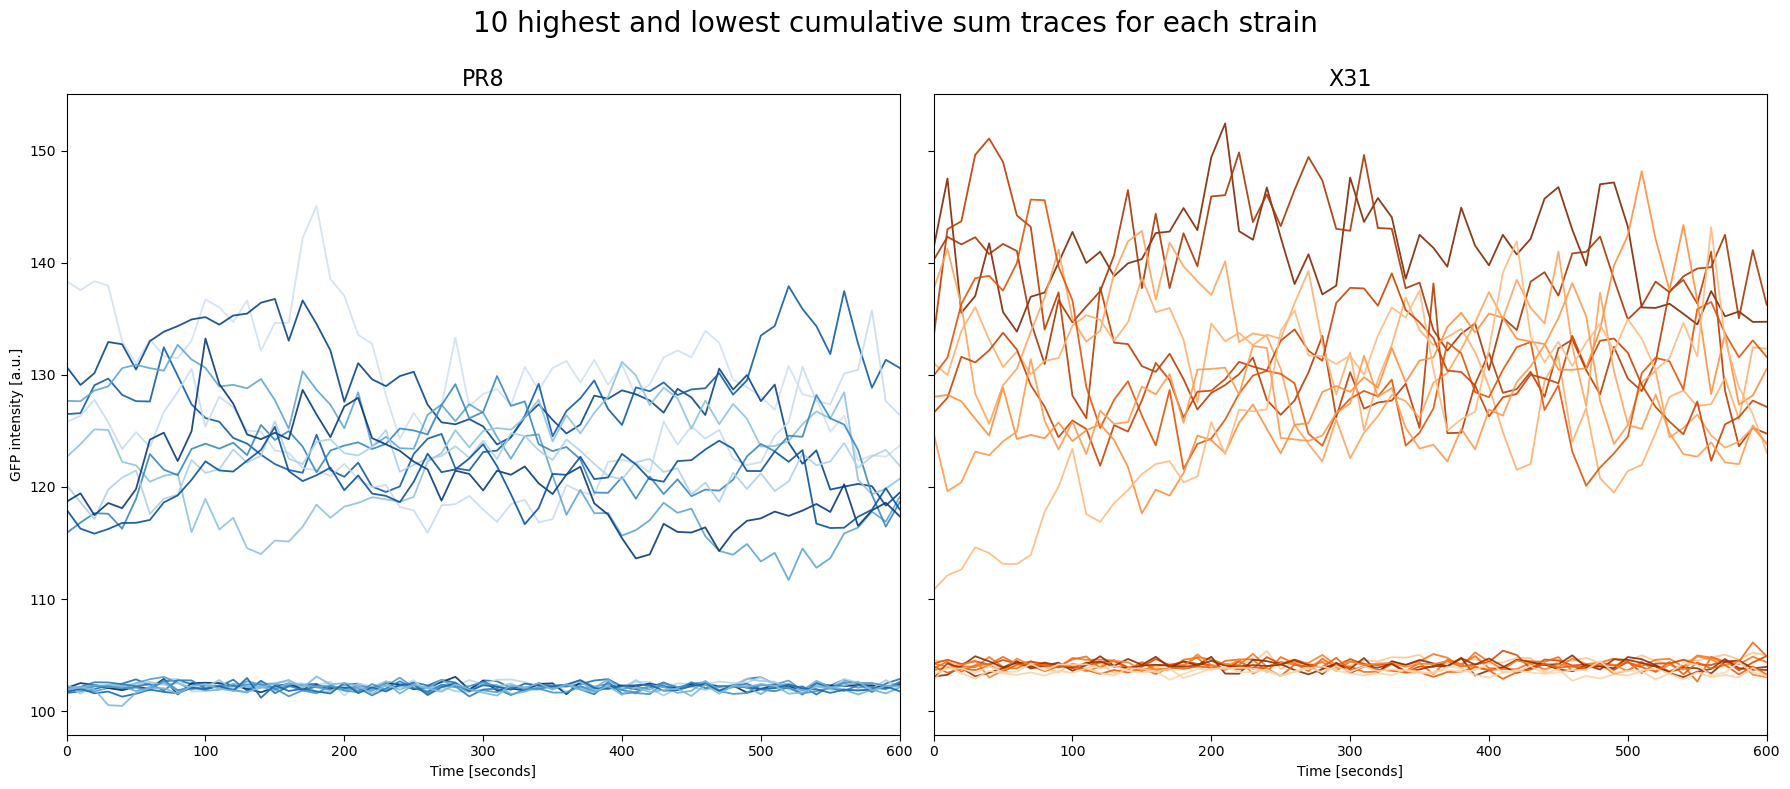

In [38]:
# --- Split data by label ---
pr8_traces = top_and_bottom_10.loc['PR8']
x31_traces = top_and_bottom_10.loc['X31']

# --- Define color palettes ---
cmap_pr8 = colormaps["Blues"]
cmap_x31 = colormaps["Oranges"]

# --- Define figure ---
fig, axs = plt.subplots(1, 2, figsize=(18, 8), sharex=True, sharey=True)

# --- Determine consistent x-limits across both datasets ---
all_timepoints = np.concatenate([pr8_traces.columns.astype(float), x31_traces.columns.astype(float)])
x_min, x_max = all_timepoints.min(), all_timepoints.max()

# --- PR8 subplot ---
n_pr8 = len(pr8_traces)
colors_pr8 = [cmap_pr8(x) for x in np.linspace(0.2, 1.0, n_pr8)]
np.random.seed(42)
np.random.shuffle(colors_pr8)

for color, (idx, row) in zip(colors_pr8, pr8_traces.iterrows()):
    _, video, trace = idx
    axs[0].plot(row.index.astype(float), row.values, color=color, alpha=0.9, linewidth=1.3)

axs[0].set_title('PR8', fontsize=16)
axs[0].set_xlabel('Time [seconds]')
axs[0].set_ylabel('GFP intensity [a.u.]')
axs[0].set_xlim(x_min, x_max)
axs[0].grid(False)
axs[0].tick_params(axis='both', length=4, width=0.8, color='black')

# --- X31 subplot ---
n_x31 = len(x31_traces)
colors_x31 = [cmap_x31(x) for x in np.linspace(0.2, 1.0, n_x31)]
np.random.shuffle(colors_x31)

for color, (idx, row) in zip(colors_x31, x31_traces.iterrows()):
    _, video, trace = idx
    axs[1].plot(row.index.astype(float), row.values, color=color, alpha=0.9, linewidth=1.3)

axs[1].set_title('X31', fontsize=16)
axs[1].set_xlabel('Time [seconds]')
axs[1].set_xlim(x_min, x_max)
axs[1].grid(False)
axs[1].tick_params(axis='both', length=4, width=0.8, color='black')

# --- Shared figure styling ---
plt.suptitle('10 highest and lowest cumulative sum traces for each strain', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])

# --- Save and show ---
fig.savefig('Exploring_Dataset/10_highest_lowest_cumsum_traces_per_strain.png', dpi=300)
plt.show()
plt.close(fig)